In [1]:
import numpy as np
import pandas as pd
import pydot
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, Reshape, Activation, BatchNormalization, Add
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Conv2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn import metrics 
from statistics import mean
import seaborn as sns
import pydotplus
from tensorflow.keras.utils import model_to_dot

в librosa.feature.melspectrogram параметры
hop_length - есть кол-во отсчётов между началами двух последовательных окон.
win_length - есть размер окна
этими двумя параметрами определяется и перекрытие двух соседних окон
n_fft - length of the FFT window. Each frame of audio is windowed by window(). The window will be of length win_length and then padded with zeros to match n_fft. If unspecified, defaults to win_length = n_fft.

Эти три параметра надо проконтролировать, не расчитывая на дефолтные значения

In [6]:
fulldatasetpath = 'P:\Study\Phonemes Classification\TIMIT dataset'
train_dir = os.path.join(fulldatasetpath, 'data\TRAIN')
test_dir = os.path.join(fulldatasetpath, 'data\TEST')
train_dir

'P:\\Study\\Phonemes Classification\\TIMIT dataset\\data\\TRAIN'

In [28]:
data = []
rates = []
for dialect in os.listdir(train_dir):
    for reader in os.listdir(os.path.join(train_dir, dialect)):
        files = [f for f in os.listdir(os.path.join(train_dir, dialect, reader))
             if os.path.isfile(os.path.join(train_dir, dialect, reader, f))]
        examples = [x[:-4] for x in files if x[-3:] != 'wav']
        examples = np.unique(np.array(examples))
        
        for ex in examples:
            wav_file = os.path.join(train_dir, dialect, reader, ex + '.WAV')
            phn_file = os.path.join(train_dir, dialect, reader, ex + '.PHN')
            
            audio, sample_rate = librosa.load(wav_file, res_type='kaiser_fast', sr=32000) 
            phonemesdf = pd.read_csv(phn_file, sep=' ', names=['begin', 'end', 'phoneme'])
            rates.append(sample_rate)
            
            for index, row in phonemesdf.iterrows():
                phoneme = row['phoneme']
                if phoneme == 'h#':
                    continue
                phoneme_audio = audio[row['begin'] * 2 : row['end'] * 2].copy()
                mfccs = librosa.feature.mfcc(y=phoneme_audio, sr=sample_rate, n_mfcc=40, n_fft=320, win_length=80, hop_length=80)
                data.append([mfccs, phoneme])

p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=280
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=312
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=186
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=260
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=256
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length

p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=206
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=194
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=244
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=102
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=210
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length

<BarContainer object of 60 artists>

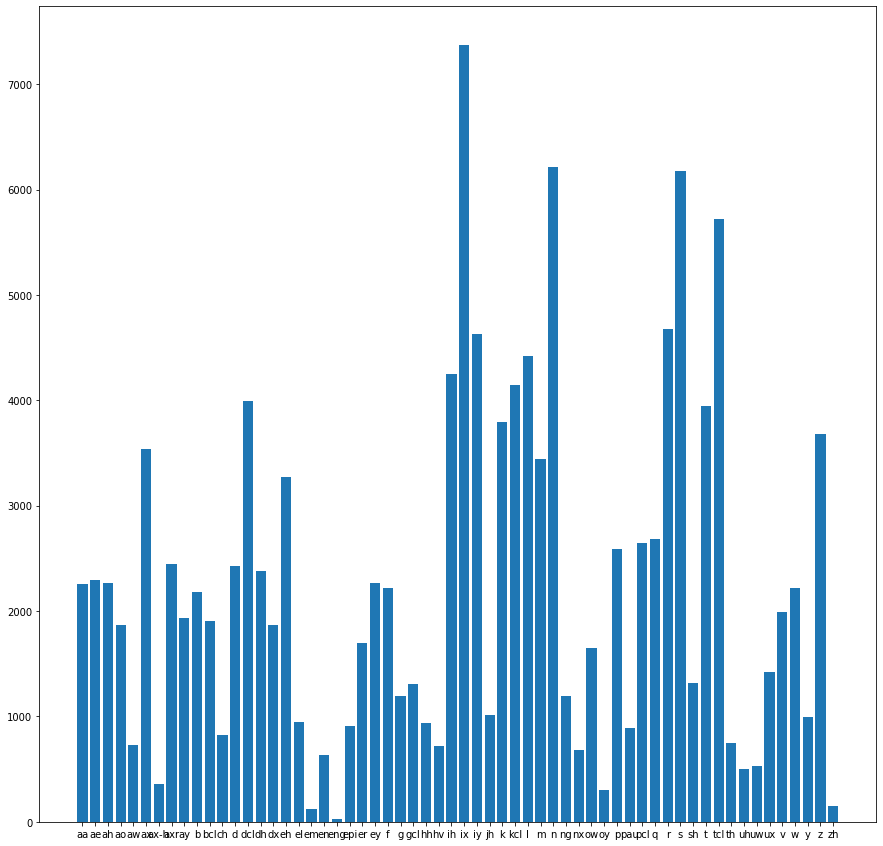

In [64]:
phonemes = [x[1] for x in train_data]
phonemes = np.array(phonemes)
unique_phonemes = np.unique(phonemes)
counts = []
for phon in unique_phonemes:
    c = np.count_nonzero(phonemes == phon)
    counts.append(c)
plt.figure(figsize = (15, 15))
plt.bar(unique_phonemes, counts)

(array([1., 0., 2., 0., 0., 2., 0., 2., 0., 0., 2., 0., 4., 0., 0., 2., 0.,
        2., 0., 0., 2., 0., 2., 0., 0., 1., 0., 2., 0., 0., 2., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 1.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. , 20.4, 20.8, 21.2, 21.6,
        22. , 22.4, 22.8, 23.2, 23.6, 24. ]),
 <BarContainer object of 60 artists>)

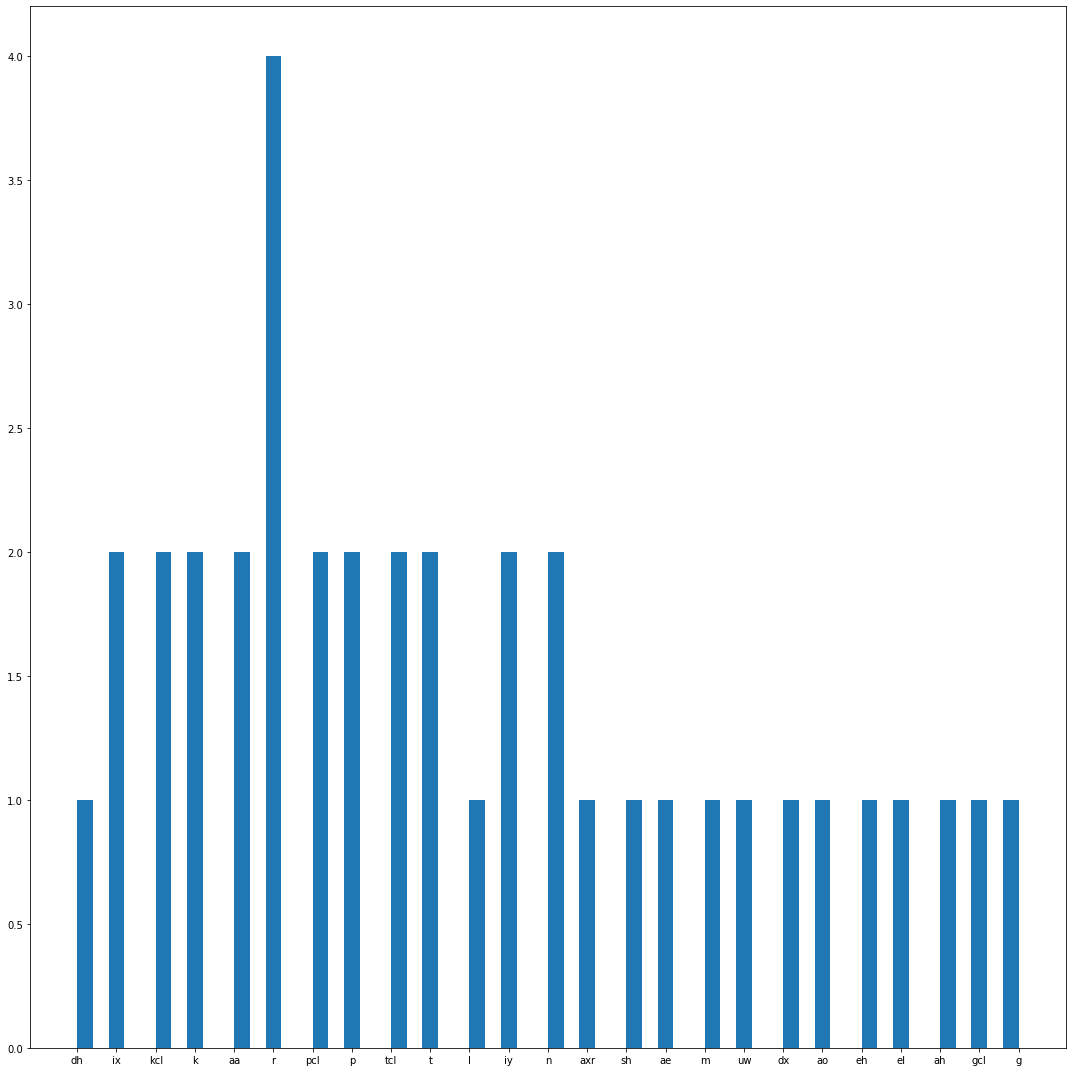

In [60]:
# print(mean([x[2] for x in train_data]))
print(np.unique(rates))
print(mean([x[0].shape[1] for x in data]))
# print(len(train_data))

hist_data = [x[0].shape[1] for x in data]
hist_data = np.array(hist_data)
print(np.count_nonzero(hist_data > 50))
print(np.count_nonzero(hist_data < 10))
# hist_data
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(15)
fig.set_figwidth(15)
# We can set the number of bins with the `bins` kwarg
axs.hist(hist_data, bins=305)
axs.set_xlim(-10, 300)
start, end = axs.get_xlim()
ticks = axs.xaxis.set_ticks(np.arange(-10, 300, 10))
start, end = axs.get_ylim()
ticks = axs.yaxis.set_ticks(np.arange(0, int(end), 500))
# axs[1].hist(y, bins=n_bins)
# print(type(train_data_array))
# print(train_data_array.shape)
# print(train_data_array[:,0].shape[1])

In [7]:
def get_example_data(wav_file, phn_file):
    target_width = 50
    window_length = 320
    window_step = window_length // 4
    result = []
    try:
        audio, sample_rate = librosa.load(wav_file, res_type='kaiser_fast', sr=32000) 
        phonemesdf = pd.read_csv(phn_file, sep=' ', names=['begin', 'end', 'phoneme'])

        for index, row in phonemesdf.iterrows():
            phoneme = row['phoneme']
            if phoneme == 'h#':
                continue
            phoneme_audio = audio[row['begin'] * 2 : row['end'] * 2].copy()
            mfccs = librosa.feature.mfcc(y=phoneme_audio, sr=sample_rate, n_mfcc=40, 
                                         n_fft=window_length, win_length=window_length, hop_length=window_step)
#             embedding = np.mean(mfccs, axis=1)
                
            if(target_width > mfccs.shape[1]):
                paddings = tf.constant([[0, 0,], [0, (target_width - mfccs.shape[1])]])
                mfccs = np.pad(mfccs, paddings, mode='constant')
            if(target_width < mfccs.shape[1]):
                mfccs = mfccs[..., np.newaxis]
                mfccs = tf.image.resize(mfccs, [mfccs.shape[0] , target_width], method='area')[...,0].numpy()
            
            result.append([mfccs, phoneme])

    except Exception as e:
        print("Error encountered while parsing file: ", wav_file)
    return result

In [8]:
def inception_module(inputs):
    x1 = Conv2D(filters=32, kernel_size=1, padding='same', activation='relu')(inputs)
    x1 = Conv2D(filters=64, kernel_size=5, padding='same', activation='relu')(x1)
    x2 = Conv2D(filters=32, kernel_size=1, padding='same', activation='relu')(inputs)
    x2 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x2)
    x3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    x3 = Conv2D(filters=32, kernel_size=1, padding='same', activation='relu')(x3)
    x4 = Conv2D(filters=32, kernel_size=1, padding='same', activation='relu')(inputs)
    concat = Concatenate(axis=3)([x1, x2, x3, x4])
    return concat

def conv_block(inputs, filters):
    x1 = Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(inputs)
    x1 = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x1)
    x1 = Conv2D(filters=2*filters, kernel_size=1, padding='same', activation='relu')(x1)
    x2 = Conv2D(filters=2*filters, kernel_size=1, padding='same', activation='relu')(inputs)
    x = Add()([x1, x2])
    outputs = Activation('relu')(x)
    return outputs

def identity_block(inputs, filters):
    x1 = Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(inputs)
    x1 = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x1)
    x1 = Conv2D(filters=filters, kernel_size=1, padding='same', activation='relu')(x1)
#     x2 = Conv2D(filters=2*filters, kernel_size=1, padding='same', activation='relu')(inputs)
    x = Add()([x1, inputs])
    outputs = Activation('relu')(x)
    return outputs
    

In [9]:
train_data = []
for dialect in os.listdir(train_dir):
    for reader in os.listdir(os.path.join(train_dir, dialect)):
        files = [f for f in os.listdir(os.path.join(train_dir, dialect, reader))
             if os.path.isfile(os.path.join(train_dir, dialect, reader, f))]
        examples = [x[:-4] for x in files if x[-3:] != 'wav']
        examples = np.unique(np.array(examples))
        
        for ex in examples:
            if 'SA' in ex:
                print(ex + ' was dropped')
                continue
            wav_file = os.path.join(train_dir, dialect, reader, ex + '.WAV')
            phn_file = os.path.join(train_dir, dialect, reader, ex + '.PHN')
            data = get_example_data(wav_file, phn_file)
            train_data += data
            
test_data = []
for dialect in os.listdir(test_dir):
    for reader in os.listdir(os.path.join(test_dir, dialect)):
        files = [f for f in os.listdir(os.path.join(test_dir, dialect, reader))
             if os.path.isfile(os.path.join(test_dir, dialect, reader, f))]
        examples = [x[:-4] for x in files if x[-3:] != 'wav']
        examples = np.unique(np.array(examples))
        
        for ex in examples:
            if 'SA' in ex:
                print(ex + ' was dropped')
                continue
            wav_file = os.path.join(test_dir, dialect, reader, ex + '.WAV')
            phn_file = os.path.join(test_dir, dialect, reader, ex + '.PHN')
            data = get_example_data(wav_file, phn_file)
            test_data += data

SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=312
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=186
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=260
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=256
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=270
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=284
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=296
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=162
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=274
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=300
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=318
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=240
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=226
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=196
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=298
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=294
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=268
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=280
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=258
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=304
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=230
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=254
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=248
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=316
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=228
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=306
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=308
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=218
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=282
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=262
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=286
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=224
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=290
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=276
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=250
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=150
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=264
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=314
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=288
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=310
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=214
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=272
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=178
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=292
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=220
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=278
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=200
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=216
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=206
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=194
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=244
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=234
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=246
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=266
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=136
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=94
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=252
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was 

p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=144
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=302
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=192
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=166
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=72
  n_fft, y.shape[-1]
p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=148
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was 

p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=190
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=236
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was 

p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=232
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=204
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was 

p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=222
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=138
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=242
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=126
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was 

p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=238
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=180
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


p:\programming tools\python_379_64\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=76
  n_fft, y.shape[-1]


SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped
SA1 was dropped
SA2 was dropped


In [10]:
print(len(train_data))
print(len(test_data))

testdf = pd.DataFrame(test_data, columns=['mfccs', 'phoneme'])
traindf = pd.DataFrame(train_data, columns=['mfccs', 'phoneme'])

135518
48993


In [11]:
X_train = np.array(traindf.mfccs.tolist())
y_train = np.array(traindf.phoneme.tolist())
X_test = np.array(testdf.mfccs.tolist())
y_test = np.array(testdf.phoneme.tolist())



le = LabelEncoder()
le.fit(y_train)
le.fit(y_test)
train_labels = le.transform(y_train)
test_labels = le.transform(y_test)
yy_train = to_categorical(train_labels)
yy_test = to_categorical(test_labels)
print(len(le.classes_))

60


In [51]:
num_rows = 40
num_columns = 50
num_channels = 1

num_labels = yy_train.shape[1]
filter_size = 3

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)

# Construct model 
# model = Sequential([
#     Input(shape=(num_rows, num_columns, num_channels)),
#     norm_layer,
#     Conv2D(filters=32, kernel_size=5, padding='valid', activation='relu'),
#     MaxPool2D(pool_size = (2, 2)),
#     Dropout(0.2),
#     Conv2D(filters=64, kernel_size=filter_size, padding='valid', activation='relu'),
#     MaxPool2D(pool_size = (2, 2)),
#     Dropout(0.2),
#     Conv2D(filters=128, kernel_size=filter_size, padding='valid', activation='relu'),
#     MaxPool2D(pool_size = (2, 2)),
#     Dropout(0.2),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(num_labels, activation='softmax')
# ])

# inputs = Input(shape=(num_rows, num_columns, num_channels))
# x = norm_layer(inputs)
# x = Conv2D(filters=16, kernel_size=filter_size, padding='same', activation='relu')(x)
# x = MaxPool2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x)
# x = Conv2D(filters=32, kernel_size=filter_size, padding='same', activation='relu')(x)
# x = MaxPool2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x)
# x = inception_module(x)
# # x = inception_module(x)
# # x = Conv2D(filters=64, kernel_size=filter_size, padding='valid', activation='relu')(x)
# # x = Dropout(0.2)(x)
# # x = Conv2D(filters=64, kernel_size=filter_size, padding='valid', activation='relu')(x)
# # x = Dropout(0.2)(x)
# # x = Conv2D(filters=128, kernel_size=filter_size, padding='valid', activation='relu')(x)
# # x = Dropout(0.2)(x)
# # x = Conv2D(filters=128, kernel_size=filter_size, padding='valid', activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Conv2D(filters=256, kernel_size=filter_size, padding='same', activation='relu')(x)
# x = AveragePooling2D(pool_size=(5, 5), strides=(3, 3))(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.2)(x)
# predictions = Dense(num_labels, activation='softmax')(x)

# model = tf.keras.Model(inputs, predictions)

# model = Sequential([
#     Input(shape=(num_rows, num_columns, num_channels)),
#     norm_layer,
    
#     Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu'),
#     MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
#     Activation('tanh'),
#     Dropout(0.2),
    
#     Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'),
#     MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
#     Activation('tanh'),
#     Dropout(0.2),
    
#     Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu'),
#     MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
#     Activation('tanh'),
#     Dropout(0.2),
    
#     Flatten(),
#     Dense(128, activation='linear'),
#     Dropout(0.2),
#     Activation('tanh'),
#     Dense(128, activation='linear'),
#     Dropout(0.2),
#     Dense(num_labels, activation='softmax')
# ])


# ResNet approach
inputs = Input(shape=(num_rows, num_columns, num_channels))
x = norm_layer(inputs)
x = ZeroPadding2D(padding=((3, 3), (3, 3)))(x)
x = Conv2D(32, 3, strides=2, activation='relu')(x)
x = conv_block(x, 64)
x = Dropout(0.2)(x)
x = identity_block(x, 128)
x = AveragePooling2D(pool_size=(5, 5), strides=(3, 3))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(num_labels, activation='softmax')(x)

model = tf.keras.Model(inputs, x)

In [52]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 40, 50, 1)]  0                                            
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 40, 50, 1)    3           input_4[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 46, 56, 1)    0           normalization_3[0][0]            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 22, 27, 32)   320         zero_padding2d[0][0]             
____________________________________________________________________________________________

In [53]:
num_epochs = 50
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet_cnn.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, yy_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_test, yy_test), callbacks=[checkpointer], verbose=1)


Epoch 1/50
530/530 [==============================] - 138s 255ms/step - loss: 2.6423 - accuracy: 0.2650 - val_loss: 1.5015 - val_accuracy: 0.5196

Epoch 00001: val_loss improved from inf to 1.50148, saving model to saved_models\weights.best.resnet_cnn.hdf5
Epoch 2/50
530/530 [==============================] - 136s 256ms/step - loss: 1.5569 - accuracy: 0.5082 - val_loss: 1.3597 - val_accuracy: 0.5610

Epoch 00002: val_loss improved from 1.50148 to 1.35965, saving model to saved_models\weights.best.resnet_cnn.hdf5
Epoch 3/50
530/530 [==============================] - 135s 255ms/step - loss: 1.3936 - accuracy: 0.5528 - val_loss: 1.2617 - val_accuracy: 0.5884

Epoch 00003: val_loss improved from 1.35965 to 1.26172, saving model to saved_models\weights.best.resnet_cnn.hdf5
Epoch 4/50
530/530 [==============================] - 135s 255ms/step - loss: 1.3066 - accuracy: 0.5801 - val_loss: 1.2205 - val_accuracy: 0.6019

Epoch 00004: val_loss improved from 1.26172 to 1.22051, saving model to sa

KeyboardInterrupt: 

In [54]:
model = tf.keras.models.load_model('saved_models/weights.best.resnet_cnn.hdf5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 40, 50, 1)]  0                                            
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 40, 50, 1)    3           input_4[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 46, 56, 1)    0           normalization_3[0][0]            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 22, 27, 32)   320         zero_padding2d[0][0]             
____________________________________________________________________________________________

Анализ качества классификации

In [55]:
def plot_cm(labels, predictions, file_name):
    cm = tf.math.confusion_matrix(labels, np.argmax(predictions, axis=-1))
    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    fig.set_figheight(20)
    fig.set_figwidth(25)
    axs = sns.heatmap(cm, annot=True, fmt="d")
    x_labels = axs.xaxis.get_ticklabels()
    for label in x_labels:
        new_text =le.inverse_transform([int(label.get_text())])[0]
        label.set_text(new_text)
    axs.xaxis.set_ticklabels(x_labels)
    y_labels = axs.yaxis.get_ticklabels()
    for label in y_labels:
        new_text =le.inverse_transform([int(label.get_text())])[0]
        label.set_text(new_text)
    axs.yaxis.set_ticklabels(y_labels)
    axs.set_title('Confusion matrix')
    axs.set_ylabel('Actual label')
    axs.set_xlabel('Predicted label')
    plt.savefig(file_name)

In [56]:
predicts = model.predict(X_test)

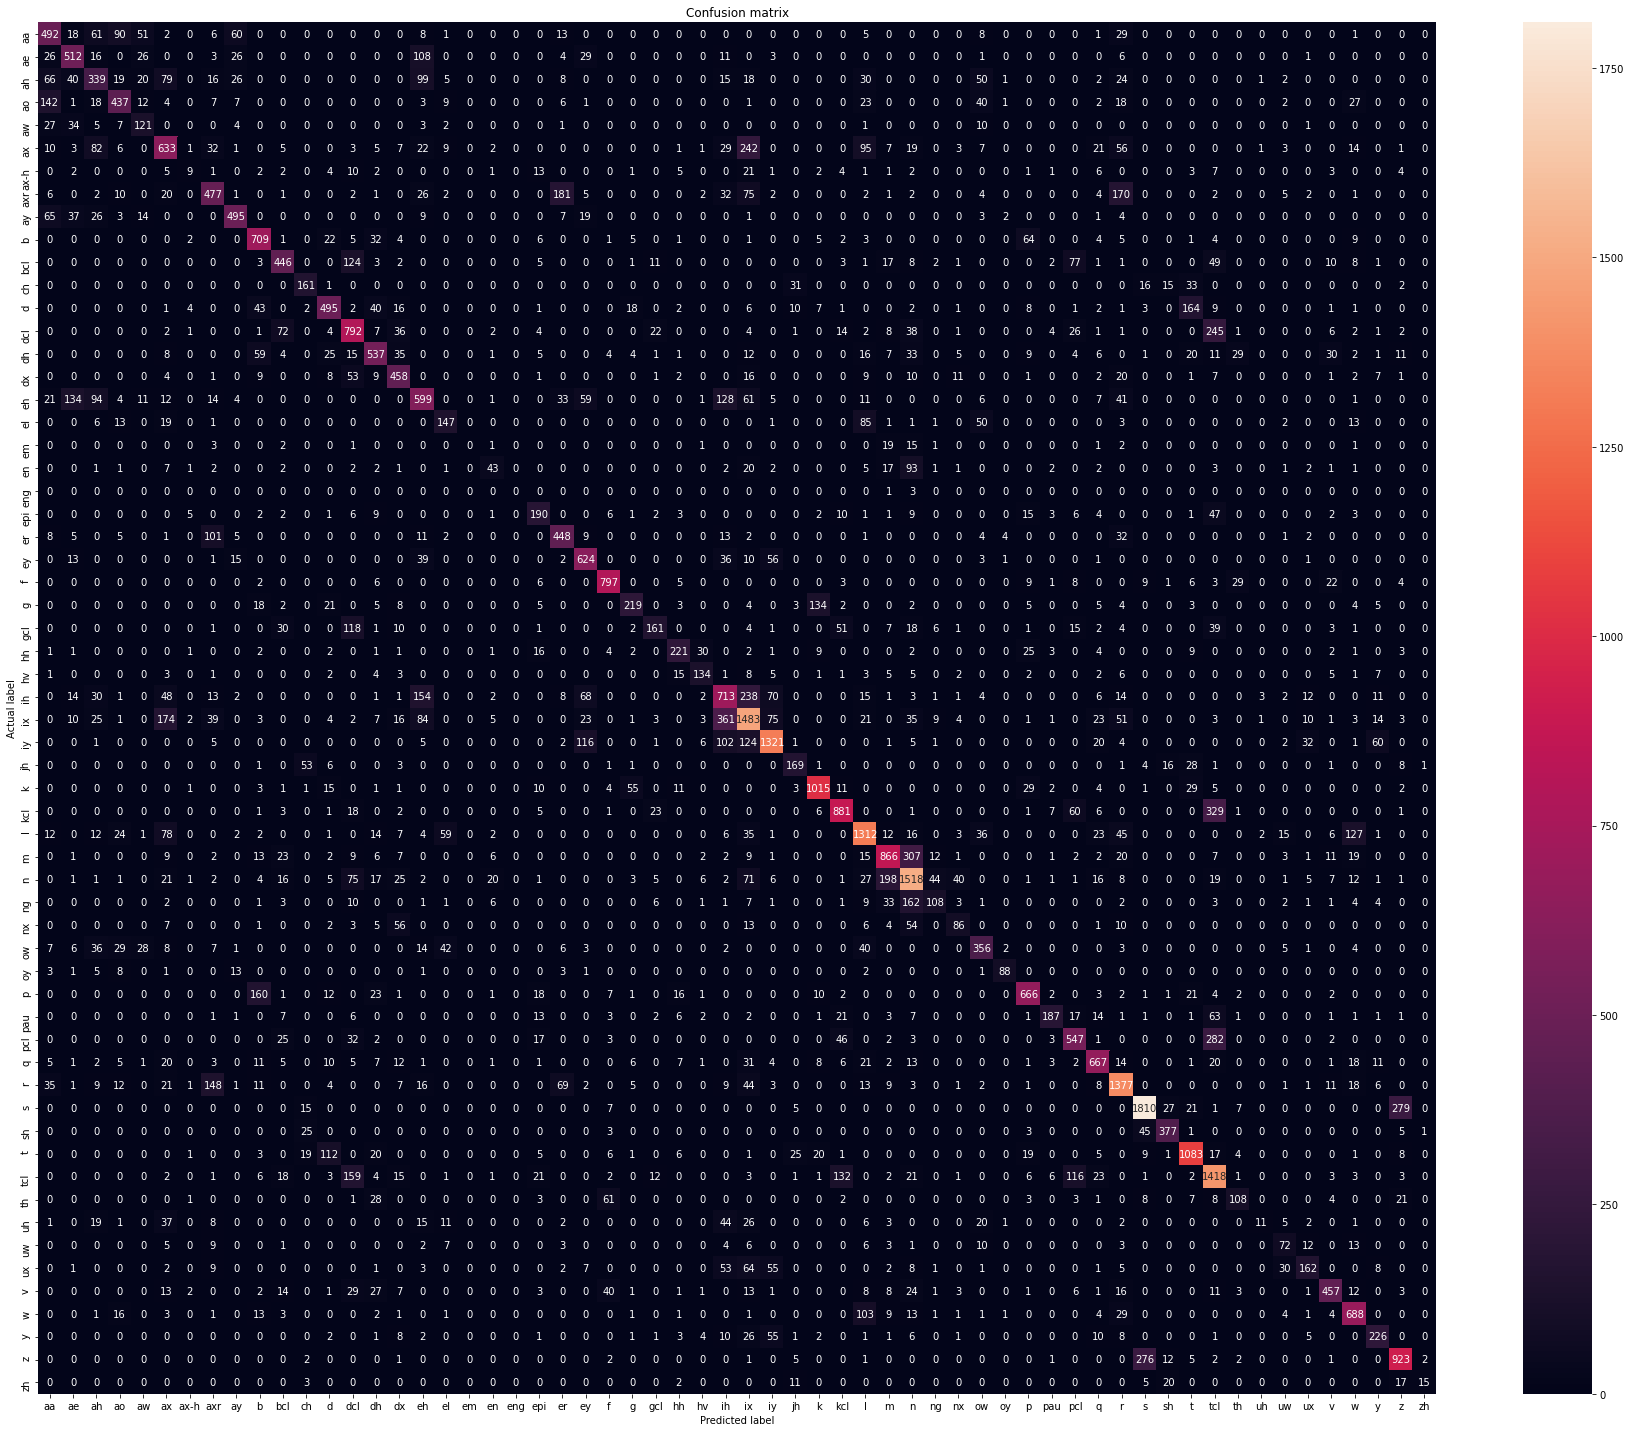

In [57]:
plot_cm(test_labels, predicts, 'confusion_matrix_resnet.png')

In [58]:
acc = metrics.accuracy_score(test_labels, np.argmax(predicts, axis=-1))
print(f'Accuracy score = {acc}')
auc = metrics.roc_auc_score(test_labels, predicts, average='macro', multi_class='ovo')
print(f'AUC score = {auc}')
f1 = metrics.f1_score(test_labels, np.argmax(predicts, axis=-1), average='macro')
print(f'F1 score = {f1}')
precision = metrics.precision_score(test_labels, np.argmax(predicts, axis=-1), average='macro')
print(f'Precision score = {precision}')

Accuracy score = 0.6410303512746719
AUC score = 0.983897736189135
F1 score = 0.5714755207022875
Precision score = 0.6084577785111541


p:\programming tools\python_379_64\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


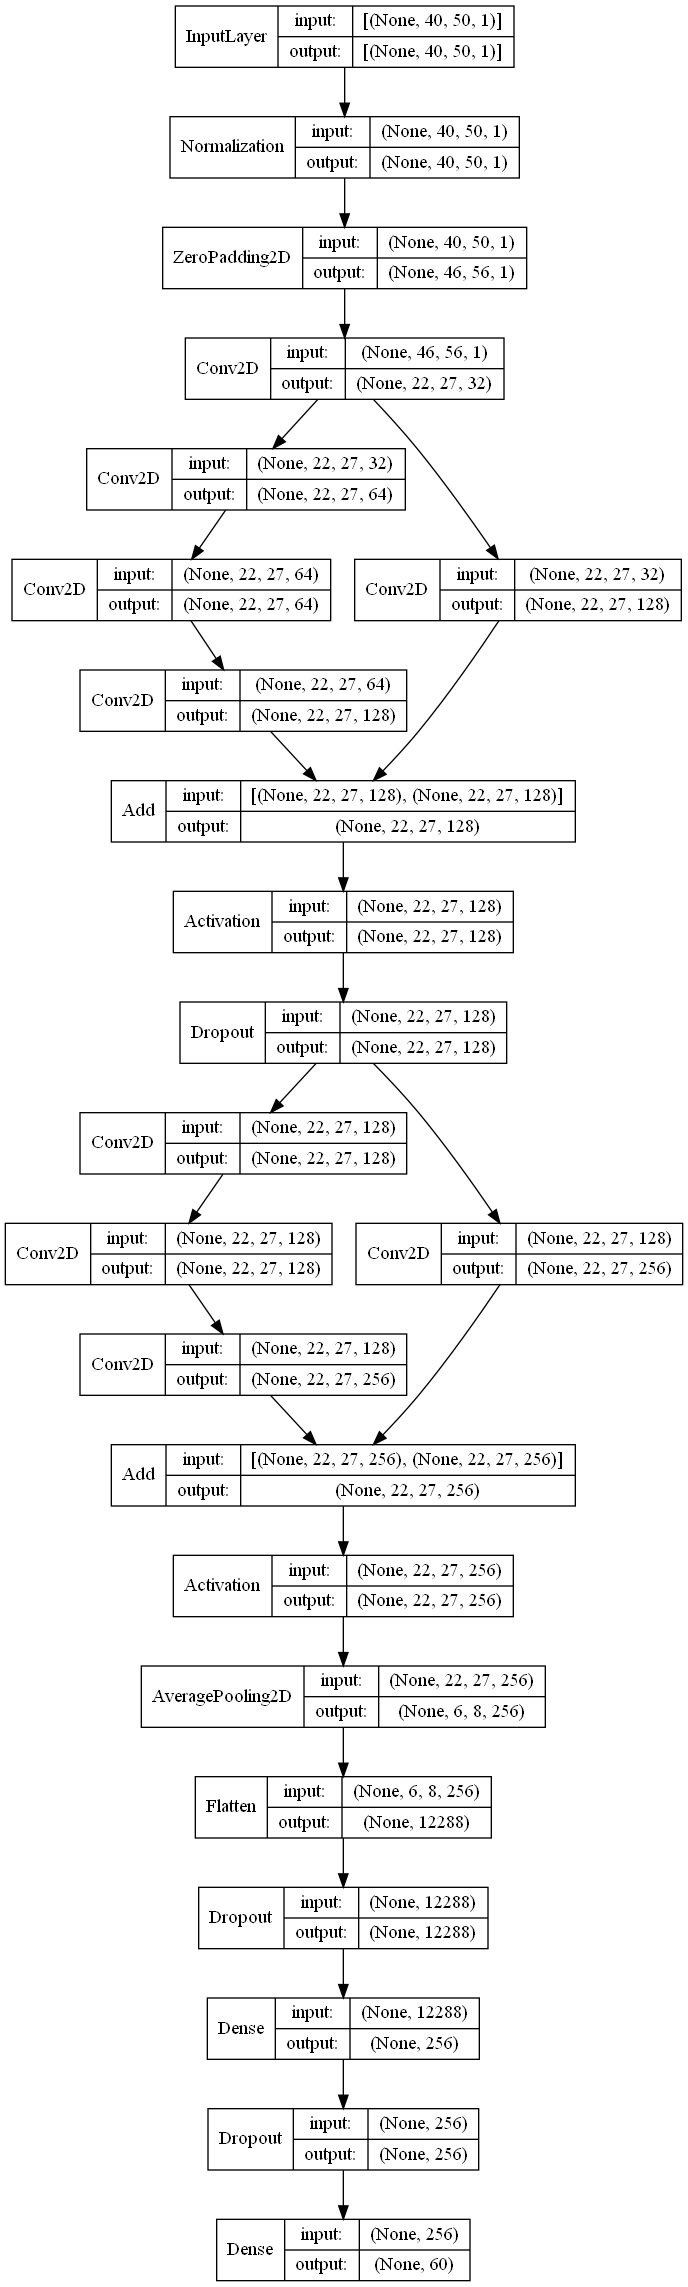

In [59]:
tf.keras.utils.plot_model(
    model,
    to_file="ResNet_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
)